# 14 Adventures in Covariance

## Imports, loadings and functions

In [1]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import pandas as pd

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

import xarray as xr

import stan
import nest_asyncio

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
# from causalgraphicalmodels import CausalGraphicalModel  # Just work in < python3.9 

In [2]:
# Add fonts to matplotlib to run xkcd

from matplotlib import font_manager

font_dirs = ["fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
# To make plots like drawing 
# plt.xkcd()

In [4]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

In [5]:
# https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def get_correlated_dataset(n, dependency, mu, scale):
    latent = np.random.randn(n, 2)
    dependent = latent.dot(dependency)
    scaled = dependent * scale
    scaled_with_offset = scaled + mu
    # return x and y of the new, correlated dataset
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]

In [6]:
# https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    #scale_x = n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    #scale_y = n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [7]:
def draw_ellipse(mu, sigma, level, plot_points=None):
    
    fig, ax_nstd = plt.subplots(figsize=(6, 6))

    dependency_nstd = sigma.tolist()

    scale = 5, 5

    x, y = get_correlated_dataset(500, dependency_nstd, mu, scale)
    
    if plot_points is not None:
        ax_nstd.scatter(plot_points[:, 0], plot_points[:, 1], s=25)

    for l in level:
        confidence_ellipse(x, y, ax_nstd, n_std=l, edgecolor='black', alpha=0.3)

    # ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
    ax_nstd.set_title('Cafés sampled - Figure 14.2')
    ax_nstd.set_xlabel('intercepts (a_cafe)')
    ax_nstd.set_ylabel('slopes (b_cafe)')
    
    ax_nstd.set_xlim(1.8, 6.2)
    ax_nstd.set_ylim(-1.9, -0.51)
    
    plt.show()

## 14.1 Varing Slopes by Contructions

### R Code 14.1

In [8]:
a = 3.5        # Average morning wait time
b = (-1)       # Average difference afternoon wait time
sigma_a = 1    # std dev in intercepts
sigma_b = 0.5  # std in slopes
rho = (-0.7)   # correlation between intercepts and slopes

### R Code 14.2

In [9]:
Mu = np.array([a, b])  # Vector
Mu

array([ 3.5, -1. ])

 ### R Code 14.3

The matrix variance and covariance:

$$ 
\begin{pmatrix}
\mbox{variance of intercepts} & \mbox{covariance of intercepts & Slopes} \\
\mbox{covariance of intercepts & Slopes} & \mbox{variance of slopes}
\end{pmatrix}
$$

And in math form:


$$
\begin{pmatrix}
\sigma^2_\alpha & \sigma_\alpha\sigma_\beta\rho \\
\sigma_\alpha\sigma_\beta\rho & \sigma^2_\beta
\end{pmatrix}
$$

### R Code 14.3

In [10]:
cov_ab = sigma_a * sigma_b * rho
Sigma = np.matrix([
    [sigma_a**2, cov_ab],
    [cov_ab, sigma_b**2]
])
Sigma

matrix([[ 1.  , -0.35],
        [-0.35,  0.25]])

### R Code 14.4

In [11]:
np.matrix([[1,2], [3, 4]])

matrix([[1, 2],
        [3, 4]])

### R Code 14.5

In [12]:
sigmas = np.array([sigma_a, sigma_b])  # Standart Deviations

sigmas

array([1. , 0.5])

In [13]:
Rho = np.matrix([
    [1, rho],
    [rho, 1]
])  # Correlation Matrix

Rho

matrix([[ 1. , -0.7],
        [-0.7,  1. ]])

In [14]:
# Multiply to get covariance matrix
Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)

Sigma

matrix([[ 1.  , -0.35],
        [-0.35,  0.25]])

### R Code 14.6

In [15]:
N_cafe = 20

### R Code 14.7

In [16]:
np.random.seed(5)   # used to replicate example

vary_effects = stats.multivariate_normal(mean=Mu, cov=Sigma).rvs(N_cafe)
vary_effects

array([[ 3.02149593, -0.9304358 ],
       [ 1.05666673, -0.12762876],
       [ 3.58546284, -0.46432203],
       [ 4.3297356 , -1.53991745],
       [ 3.27332508, -1.02933771],
       [ 4.65859716, -1.5303893 ],
       [ 3.93018946, -0.9524405 ],
       [ 5.06625508, -1.869279  ],
       [ 2.58529637,  0.0287956 ],
       [ 5.07890482, -1.39033508],
       [ 4.36801698, -1.65042937],
       [ 4.31342478, -1.47263713],
       [ 2.59854231, -0.38835499],
       [ 3.39670791, -1.09000246],
       [ 3.48373345, -1.03170127],
       [ 2.63542057, -0.88644913],
       [ 3.49374238, -1.03389681],
       [ 3.58250316, -0.94285315],
       [ 3.46768242, -0.50699357],
       [ 3.77789108, -0.54770738]])

### R Code 14.8

In [17]:
a_cafe = vary_effects[:, 0]  # Intercepts samples
b_cafe = vary_effects[:, 1]  # Slopes samples

### R Code 14.9

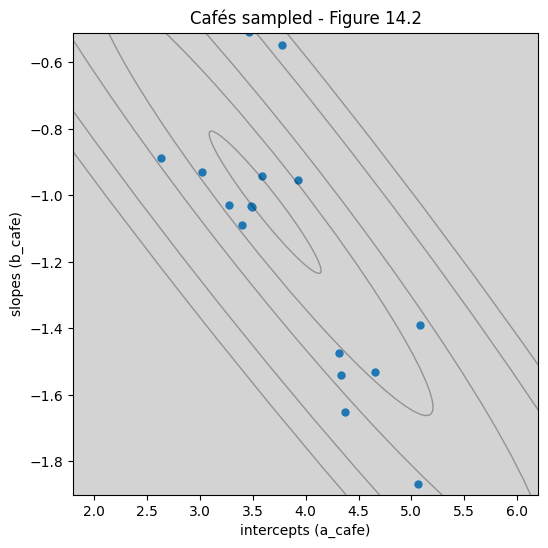

In [18]:
levels = [0.1, 0.3, 0.5, 0.8, 0.99]
draw_ellipse(mu=Mu, sigma=Sigma, level=levels, plot_points=vary_effects)

**Overthinking**: We define the *covariance* with 3 parameters: (pag 440)

 1. Firt variable standart deviations  $\sigma_\alpha$
 2. Second variable standart deviations  $ \sigma_\beta $
 3. Correlation between two variables  $\rho_{\alpha\beta}$
    
Whu the covariance is equal to $\sigma_\alpha \sigma_\beta \rho_{\alpha\beta}$?

The usual definition of the covariance between two variables $x$ and $y$ is:

$$ cov(x, y) = \mathbb{E}(xy) - \mathbb{E}(x)\mathbb{E}(y) $$


To simple variance this concept is the same:

$$ var(x) = cov(x, x) = \mathbb{E}(x^2) - \mathbb{E}(x)^2$$


If the variable with only mean equal zero ($0$), then the variance to be:

$$ var(x) = cov(x) = \mathbb{E}(x^2), \mbox{ if the } \mathbb{E}(x) = 0 $$


The correlation live in $[-1, 1]$, this is only the covariance rescaled. To be rescaled covariance just:

$$ cov(xy) = \sqrt{var(x)var(y)} \rho_{xy} $$

or better:

$$ cov(xy) = \sigma_x \sigma_y \rho_{xy} $$


### R Code 14.10

In [19]:
N_visit = 10

afternoon = np.tile([0, 1], reps=int((N_visit*N_cafe)/2))
cafe_id = np.repeat(np.arange(0, N_cafe), N_visit)

mu = a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma = 0.5  # std dev within cafes

wait = np.random.normal(mu, sigma, size=N_visit*N_cafe)
cafe_id += 1  # index from 1 to 20 cafe_id, need to Stan index

d = pd.DataFrame({'cafe': cafe_id, 'afternoon':afternoon, 'wait': wait})
d

,cafe,afternoon,wait
0,1,0,2.713830
1,1,1,1.965617
2,1,0,3.261427
3,1,1,2.836598
4,1,0,3.105162
...,...,...,...
195,20,1,4.001264
196,20,0,3.991292
197,20,1,2.764103
198,20,0,3.507337


## 14.1.3 The varing slope model

The likelihood:

$$ W_i \sim Normal(\mu_i, \sigma) $$

and the linear model:

$$ \mu_i = \alpha_{CAFÉ[i]} + \beta_{CAFÉ[i]}A_i $$


Then comes the matrix of varing intercepts and slopes, with it's covariance matrix:

Population of varying effects:
$$
\begin{bmatrix}
\alpha_{CAFÉ} \\
\beta_{CAFÉ}
\end{bmatrix} 
\sim Normal
\begin{pmatrix}
\begin{bmatrix}
\alpha \\
\beta
\end{bmatrix}, S
\end{pmatrix}
$$

construct covariance matrix:

$$S = 
\begin{pmatrix} 
\sigma_\alpha &  0 \\
0  & \sigma_\beta
\end{pmatrix}
R
\begin{pmatrix} 
\sigma_\alpha &  0 \\
0  & \sigma_\beta
\end{pmatrix}
$$

The $R$ is the correlation matrix. In this simple case $R$ is defined like:

$$
R = 
\begin{pmatrix}
1 & \rho  \\
\rho & 1
\end{pmatrix}
$$


And the priors and hyper-priors:

- prior for intercept:

$$ \alpha \sim Normal(5, 2) $$


- prior for average slope:

$$ \beta \sim Normal(-1, 0.5) $$



- prior for stddev within cafés

$$\sigma \sim Exponential(1) $$


- prior for stddev among cafés

$$ \sigma_\alpha \sim Exponential(1) $$


- prior for stddev among slopes

$$ \sigma_\beta \sim Exponential(1) $$

- prior for correlation  matrix

$$ R \sim LKJcorr(2) $$

### R Code 14.11

In [20]:
# Dont have the function LKJcorr implemented in numpy or scipy
# Stan implementation - https://mc-stan.org/docs/functions-reference/lkj-correlation.html

### R Code 14.12

In [21]:
# https://mc-stan.org/docs/stan-users-guide/multivariate-hierarchical-priors.html

model = """
    data {
        int N;
        int N_cafe;
        int N_periods;
        
        array[N] real wait;
        array[N] int cafe;
        array[N] int afternoon; 
    }
    
    parameters {
        real<lower=0> sigma;
        vector<lower=0>[2] sigma_cafe;
        
        vector[N_cafe] alpha_cafe;
        vector[N_cafe] beta_cafe;
        
        real alpha;  // Like bar_alpha (hyper-prior)
        real beta;   // Like bar_beta (hyper-prior)
        
        corr_matrix[N_periods] Rho;
    }
    
    model {
        vector[N] mu;
        vector[2] Y_cafe[N_cafe];
        vector[2] MU_cafe;
        
        //(sigma) - Prior to likelihood
        sigma ~ exponential(1);  
        
        
        // (sigma_cafe) - Hyper Prior
        sigma_cafe ~ exponential(1);
        
        // (Rho) - Hyper Prior
        Rho ~ lkj_corr(2);
        
        // (MU_cafe) - Hyper Prior
        alpha ~ normal(5, 2);
        beta ~ normal(-1, 0.5);
  
        MU_cafe = [alpha, beta]';
        
        // (alpha_cafe, beta_cafe) - Prior 
        for (j in 1:N_cafe){
            Y_cafe[j] = [alpha_cafe[j], beta_cafe[j]]' ; 
        }
        
        Y_cafe ~ multi_normal(MU_cafe, quad_form_diag(Rho, sigma_cafe));  // Prior to alpha_cafe and beta_cafe
    
    
        // (mu) - Linear model
        for (i in 1:N){
            mu[i] = alpha_cafe[ cafe[i] ] + beta_cafe[ cafe[i] ] * afternoon[i];
        }
        
        // Likelihood 
        wait ~ normal(mu, sigma);
    }
"""

dat_list = {
    'N': len(d),
    'N_cafe': N_cafe,
    'N_periods': len(d.afternoon.unique()),
    'wait':  d.wait.values,
    'afternoon': d.afternoon.values,
    'cafe': d.cafe.values,
}

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_ugjcxyb4/model_3dfd2f5h.stan', line 27, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_ugjcxyb4/model_3dfd2f5h.stan', line 38, column 8: It
    is suggested to reparameterize your model to replace lkj_corr with
    lkj_corr_cholesky, the Cholesky factor variant. lkj_corr tends to run
    slower, consume more memory, and has higher risk of numerical errors.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   8% (600/8000)
Sampling:  14% (1100/8000)
Sampling:  

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = 2.39823e+30, but Covariance matrix[2,1] = 2.39823e+30 (in '/tmp/httpstan_fyb7zozt/model_3dfd2f5h.stan', line 52, column 8 to column 72)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lkj_corr_lpdf: Correlation matrix is not positive definite. (in '/tmp/httpstan_fyb7zozt/model_3dfd2f5h.stan', line 38, column 8 to column 26)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if 

In [22]:
m14_1 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list.keys()
)

In [23]:
az.summary(m14_1, hdi_prob=0.89)

/home/notebook/Projects/probability/BAYES/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.495,0.027,0.451,0.538,0.000,0.000,4357.0,3254.0,1.0
sigma_cafe[0],0.957,0.158,0.716,1.193,0.003,0.002,3994.0,2980.0,1.0
sigma_cafe[1],0.452,0.110,0.283,0.622,0.002,0.002,1924.0,1646.0,1.0
alpha_cafe[0],2.947,0.207,2.612,3.260,0.003,0.002,5429.0,3245.0,1.0
alpha_cafe[1],1.106,0.220,0.743,1.444,0.004,0.003,3831.0,3158.0,1.0
alpha_cafe[2],3.717,0.204,3.400,4.048,0.003,0.002,3426.0,2732.0,1.0
alpha_cafe[3],4.152,0.197,3.831,4.457,0.003,0.002,4650.0,3414.0,1.0
alpha_cafe[4],3.307,0.205,2.952,3.610,0.003,0.002,5422.0,3047.0,1.0
alpha_cafe[5],4.839,0.206,4.519,5.175,0.003,0.002,4297.0,3300.0,1.0
alpha_cafe[6],4.254,0.202,3.914,4.573,0.003,0.002,4750.0,2907.0,1.0


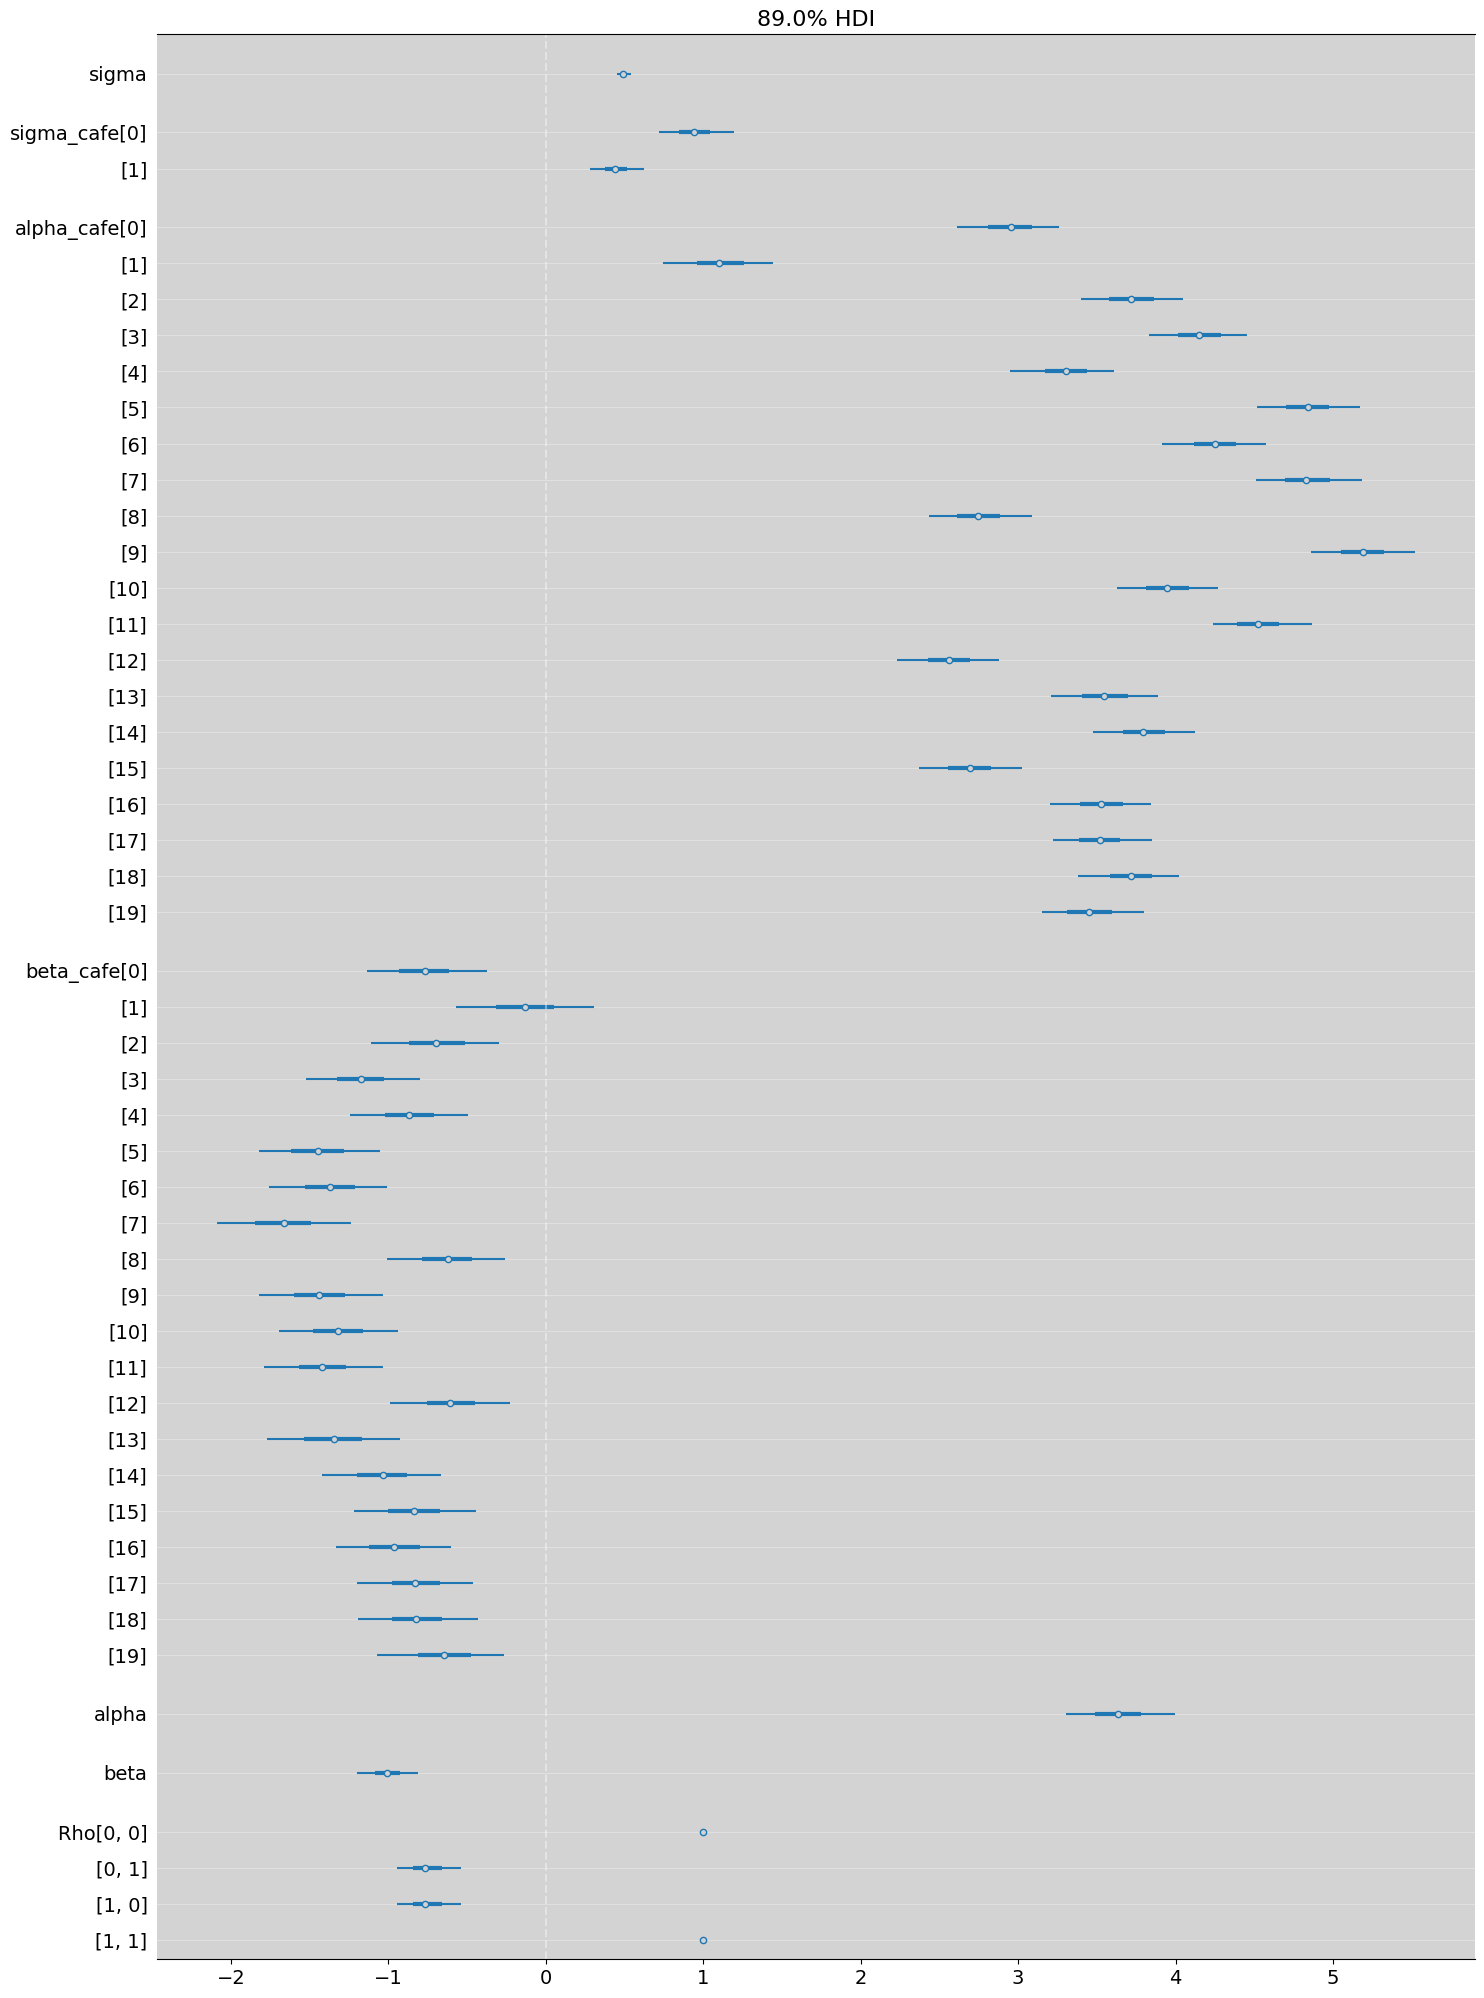

In [24]:
az.plot_forest(m14_1, hdi_prob=0.89, combined=True, figsize=(17, 25))
plt.grid(axis='y', color='white', alpha=0.3)
plt.axvline(x=0, ls='--', color='white', alpha=0.4)
plt.show()

### R Code 14.13

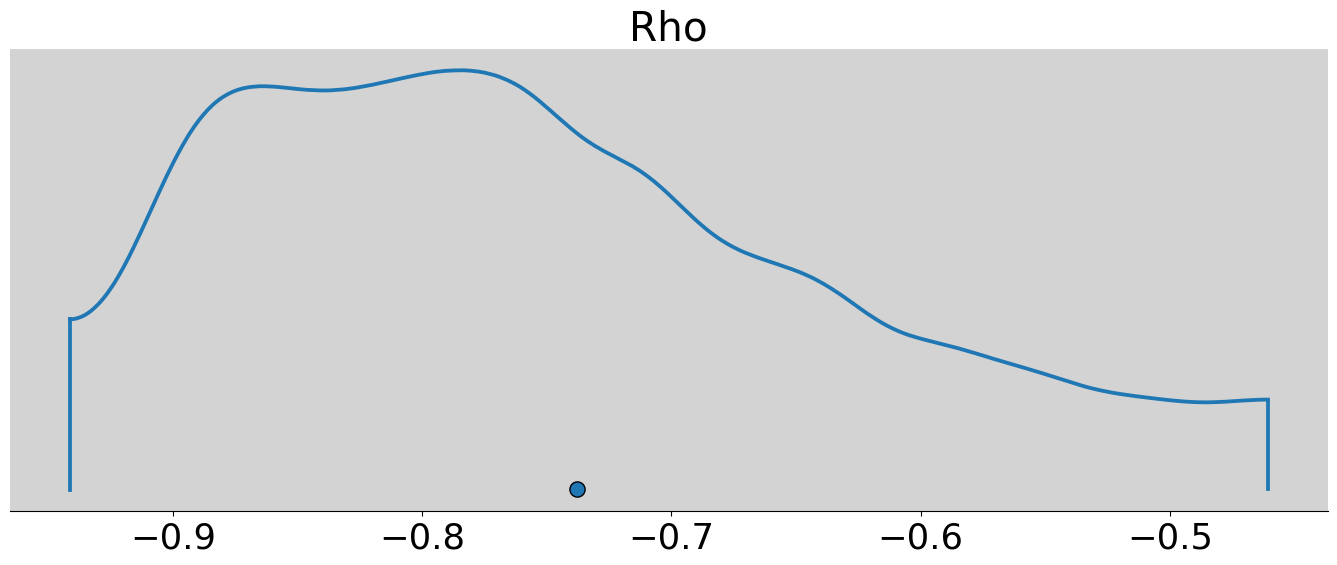

In [25]:
az.plot_density(m14_1.posterior.Rho.sel(Rho_dim_0=0, Rho_dim_1=1), figsize=(17, 6))
plt.xlabel = 'Correlation'
plt.ylabel = 'Density'
plt.show()

### R Code 14.14 & R Code 14.15

In [26]:
post_alpha = m14_1.posterior.alpha.mean().values
post_beta = m14_1.posterior.beta.mean().values

post_sigma_alpha = m14_1.posterior.sigma_cafe.sel(sigma_cafe_dim_0=0).mean().values
post_sigma_beta = m14_1.posterior.sigma_cafe.sel(sigma_cafe_dim_0=1).mean().values
post_rho = m14_1.posterior.Rho.sel(Rho_dim_0=0, Rho_dim_1=1).mean().values

print('Posterior alpha:', post_alpha)
print('Posterior beta:', post_beta)
print('Posterior sigma alpha:', post_sigma_alpha)
print('Posterior sigma beta:', post_sigma_beta)
print('Posterior Rho:', post_rho)

Posterior alpha: 3.6374425853449144
Posterior beta: -1.0059187089496733
Posterior sigma alpha: 0.9573757649370362
Posterior sigma beta: 0.4519766747386484
Posterior Rho: -0.7379419991634905


In [27]:
post_matrix_sigma_alpha_beta = np.matrix([[post_sigma_alpha, 0],[0, post_sigma_beta]])
post_matrix_sigma_alpha_beta

matrix([[0.95737576, 0.        ],
        [0.        , 0.45197667]])

In [28]:
post_matrix_rho = np.matrix([[1, post_rho],[post_rho, 1]])
post_matrix_rho

matrix([[ 1.      , -0.737942],
        [-0.737942,  1.      ]])

In [29]:
post_Sigma = post_matrix_sigma_alpha_beta * post_matrix_rho * post_matrix_sigma_alpha_beta
post_Sigma

matrix([[ 0.91656836, -0.319316  ],
        [-0.319316  ,  0.20428291]])

In [30]:
a1 = [d.loc[(d['afternoon'] == 0) & (d['cafe'] == i)]['wait'].mean() for i in range(1, N_cafe+1)]
b1 = [d.loc[(d['afternoon'] == 1) & (d['cafe'] == i)]['wait'].mean() for i in range(1, N_cafe+1)]

# Remember that in R Code 14.1 above, the data is build as
# a = 3.5        # Average morning wait time
# b = (-1)       # Average difference afternoon wait time
# because this, b value is b - a, like this

b1 = [b1[i] - a1[i] for i in range(len(a1))]

In [31]:
# Extract posterior means of partially polled estimates
a2 = [m14_1.posterior.alpha_cafe.sel(alpha_cafe_dim_0=i).mean().values for i in range(N_cafe)]
b2 = [m14_1.posterior.beta_cafe.sel(beta_cafe_dim_0=i).mean().values for i in range(N_cafe)]

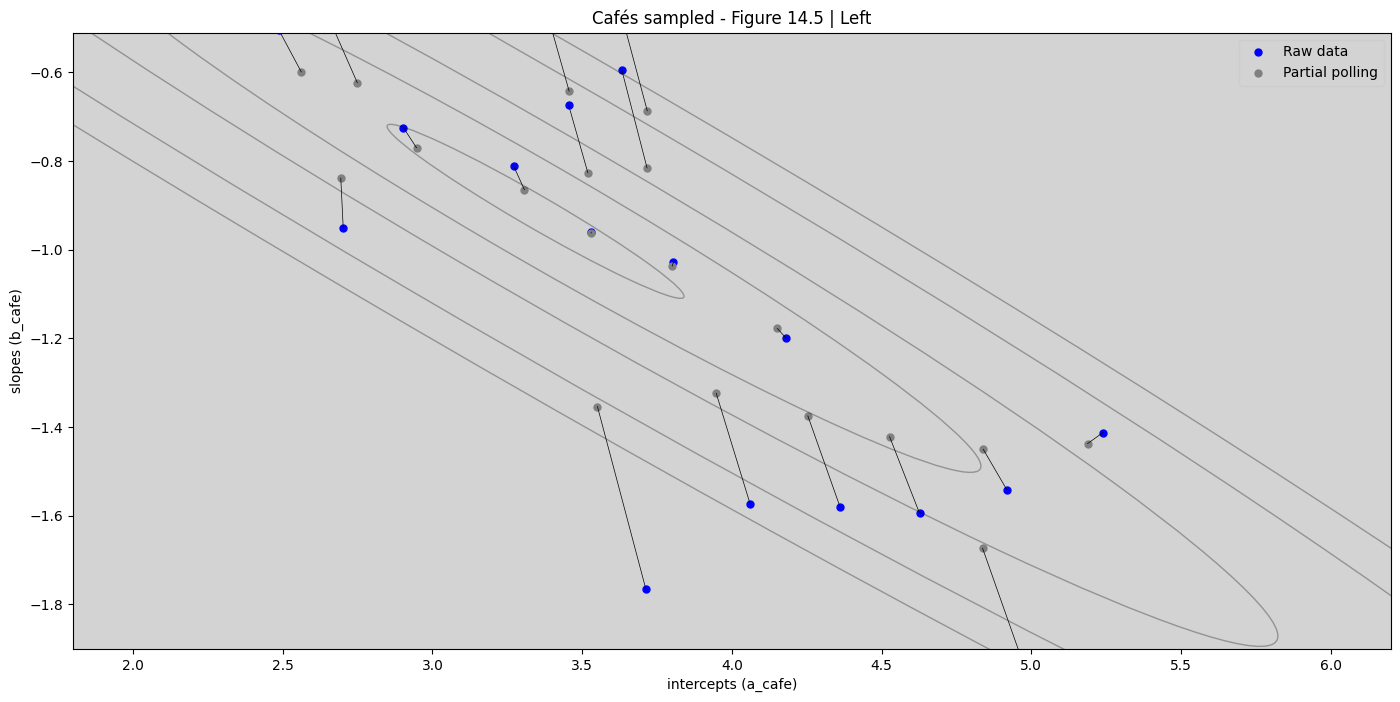

In [32]:
fig, ax_nstd = plt.subplots(figsize=(17, 8))

mu = np.array([post_alpha, post_beta])
dependency_nstd = post_Sigma.tolist()

scale = 5, 5

level = [0.1, 0.3, 0.5, 0.8, 0.99]

x, y = get_correlated_dataset(500, dependency_nstd, mu, scale)


ax_nstd.scatter(a1, b1, s=25, color='b')
ax_nstd.scatter(a2, b2, s=25, facecolor='gray')

ax_nstd.plot([a1, a2], [b1, b2], 'k-', linewidth=0.5)
    

for l in level:
    confidence_ellipse(x, y, ax_nstd, n_std=l, edgecolor='black', alpha=0.3)

# ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
ax_nstd.set_title('Cafés sampled - Figure 14.5 | Left')
ax_nstd.set_xlabel('intercepts (a_cafe)')
ax_nstd.set_ylabel('slopes (b_cafe)')


ax_nstd.set_xlim(1.8, 6.2)
ax_nstd.set_ylim(-1.9, -0.51)

# ax_nstd.legend()
ax_nstd.legend(['Raw data', 'Partial polling'])

plt.plot(1,2, c='r')

plt.show()

### R Code 14.16 & R Code 14.17

In [33]:
wait_morning_1 = (a1)
wait_afternoon_1 = [sum(x) for x in zip(a1, b1)]
wait_morning_2 = (a2)
wait_afternoon_2 = [sum(x) for x in zip(a2, b2)]

In [34]:
# now shrinkage distribution by simulation  

v = np.random.multivariate_normal(mu ,post_Sigma, 1000)
v[:, 1] = [sum(x) for x in v]  # calculation afternoon wait
Sigma_est2 = np.cov(v[:, 0], v[:, 1])

mu_est2 = [0, 0]  # Empty vector mu
mu_est2[0] = mu[0] 
mu_est2[1] = mu[0] + mu[1]

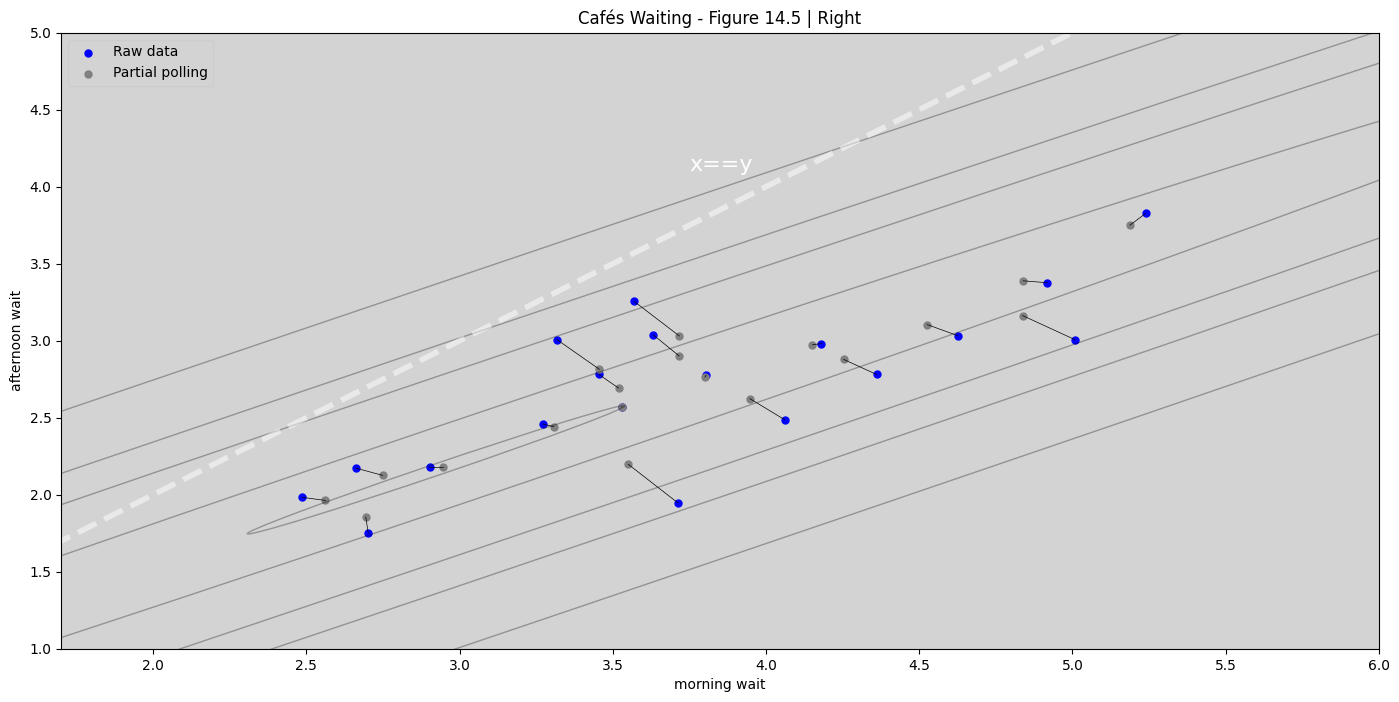

In [35]:
fig, ax_nstd = plt.subplots(figsize=(17, 8))

scale = 5, 5
#level = [0.1, 0.3, 0.5, 0.8, 0.99]
level = [0.1, 0.69, 1.5, 2.0, 3.0]

dependency_nstd = Sigma_est2.tolist()
x, y = get_correlated_dataset(500, dependency_nstd, mu_est2, scale)

ax_nstd.scatter(wait_morning_1, wait_afternoon_1, s=25, color='b')
ax_nstd.scatter(wait_morning_2, wait_afternoon_2, s=25, facecolor='gray')

ax_nstd.plot([wait_morning_1, wait_morning_2],
             [wait_afternoon_1, wait_afternoon_2], 
             'k-', linewidth=0.5)

for l in level:
    confidence_ellipse(x, y, ax_nstd, n_std=l, edgecolor='black', alpha=0.3)

ax_nstd.set_title('Cafés Waiting - Figure 14.5 | Right')
ax_nstd.set_xlabel('morning wait')
ax_nstd.set_ylabel('afternoon wait')

ax_nstd.plot([0, 10], [0, 10], ls='--', color='white', alpha=0.5, linewidth=4)
ax_nstd.text(3.75, 4.1, "x==y",color='white', fontsize=16)

ax_nstd.set_xlim(1.7, 6)
ax_nstd.set_ylim(1, 5)

# ax_nstd.legend()
ax_nstd.legend(['Raw data', 'Partial polling'])

plt.plot(1,2, c='r')

plt.show()

## 14.2 Advanced varing Slopes

### R Code 14.18

In [36]:
# Previous chimpanzees models is in chapter 11

df = pd.read_csv('./data/chimpanzees.csv', sep=';')
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


In [38]:
df['treatment'] = 1 + df['prosoc_left'] + 2 * df['condition']  # Build the treatment data
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,1,NaN,0,1,2,0,1,0,1
1,1,NaN,0,1,4,0,0,1,1
2,1,NaN,0,1,6,1,0,0,2
3,1,NaN,0,1,8,0,1,0,1
4,1,NaN,0,1,10,1,1,1,2


$$ L_i \sim  Binomial(1, p_i) $$

$$ logit(p_i) = \gamma_{_{TID}[i]} + \alpha_{_{ACTOR}[I], _{TID}[I]} + \beta_{_{BLOCK}[I], _{TID}[I]} $$

$$\begin{bmatrix}
\alpha_{j, 1} \\
\alpha_{j, 2} \\
\alpha_{j, 3} \\
\alpha_{j, 4} \end{bmatrix} \sim MVNormal
\begin{pmatrix}
\begin{bmatrix}
0 \\
0 \\
0 \\
0 
\end{bmatrix} , S_{_{ACTOR}}
\end{pmatrix}$$

$$\begin{bmatrix}
\beta_{j, 1} \\
\beta_{j, 2} \\
\beta_{j, 3} \\
\beta_{j, 4} \end{bmatrix} \sim MVNormal
\begin{pmatrix}
\begin{bmatrix}
0 \\
0 \\
0 \\
0 
\end{bmatrix} , S_{_{BLOCK}}
\end{pmatrix}$$

$$\gamma_{_{TID}} \sim Normal(0, 1)$$

For to $S_{_{ACTOR}}$:

$$\sigma_{_{ACTOR}} \sim Exponential(1)$$

$$ \rho_{_{ACTOR}} \sim dlkjcorr(4)  $$

For to $S_{_{BLOCK}}$:
$$ \sigma_{_{BLOCK}} \sim Exponential(1) $$

$$ \rho_{_{BLOCK}} \sim dlkjcorr(4)  $$


In [43]:
model = """
    data {
        int N;
        int qty_chimpanzees;
        int qty_blocks;
        int qty_treatments;
        
        array[N] int pulled_left;
        array[N] int actor;
        array[N] int block;
        array[N] int treatment;
    }
    
    parameters{
        vector[qty_treatments] gamma;
        matrix[qty_chimpanzees, qty_treatments] alpha;
        matrix[qty_blocks, qty_treatments] beta;
        
        corr_matrix[qty_treatments] Rho_actor;
        vector<lower=0>[qty_treatments] sigma_actor;
        
        corr_matrix[qty_treatments] Rho_block;
        vector[qty_treatments] sigma_block;
    }
    
    model {
        vector[N] p;
        vector[qty_chimpanzees] Y_alpha[qty_treatments];
    
        // Hyper Priors
        Rho_actor ~ lkj_corr(4);
        sigma_actor ~ exponential(1);
        
        Rho_block ~ lkj_corr(4);
        sigma_block ~ exponential(1);
        
    
        // Priors
        gamma ~ normal(0, 1);
        
        for (j in 1:qty_treatments){
            Y_alpha[j] = alpha[][j];
        }
        
        
        Y_alpha ~ multi_normal(0, quad_form_diag(Rho_actor, sigma_actor));
        beta ~ multi_normal(0, quad_form_diag(Rho_block, sigma_block));
        
        
        // Linear model
        for (i in 1:N){
            p[i] = gamma[ treatment[i] ] + alpha[ actor[i], treatment[i] ] + beta[ block[i], treatment[i] ];
            p[i] = inv_logit(p[i]);
        }
    
    
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
 
"""


dat_list = df[['pulled_left', 'actor', 'block', 'treatment']].to_dict('list')
dat_list['N'] = len(df)
dat_list['qty_chimpanzees'] = len(df['actor'].unique())
dat_list['qty_blocks'] = len(df['block'].unique())
dat_list['qty_treatments'] = len(df['treatment'].unique())

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

RuntimeError: Warning in '/tmp/httpstan__urf5q9r/model_dma324es.stan', line 28, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Semantic error in '/tmp/httpstan__urf5q9r/model_dma324es.stan', line 42, column 12 to column 36:
   -------------------------------------------------
    40:          
    41:          for (j in 1:qty_treatments){
    42:              Y_alpha[j] = alpha[][j];
                     ^
    43:          }
    44:          
   -------------------------------------------------

Ill-typed arguments supplied to assignment operator =: lhs has type vector and rhs has type row_vector